In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [2]:
# Load the similarity matrix
sim_mat = np.loadtxt('sim_mat.txt')

In [3]:
# Load labels from the labels.txt file
with open('labels.txt', 'r') as f:
    labels = f.read().splitlines()

In [4]:
# Create a mapping of image to subject
image_to_subject = {}
for label in labels:
    subject_id = label.split('_')[0]  # Extract the subject id (e.g., '001' from '001_01.npy')
    image_to_subject[label] = subject_id

In [5]:
# Number of images (assuming square matrix)
num_images = len(sim_mat)

In [6]:
print(num_images)

3000


In [7]:
# Step 1a: Extract genuine and impostor scores
def extract_scores(sim_mat, labels, image_to_subject):
    genuine_scores = []
    impostor_scores = []

    for i in range(num_images):
        for j in range(num_images):
            if image_to_subject[labels[i]] == image_to_subject[labels[j]]:
                # Genuine score (same subject)
                genuine_scores.append(sim_mat[i, j])
            else:
                # Impostor score (different subject)
                impostor_scores.append(sim_mat[i, j])

    return np.array(genuine_scores), np.array(impostor_scores)

In [8]:
genuine_scores, impostor_scores = extract_scores(sim_mat, labels, image_to_subject)

In [9]:
# Save genuine scores to a text file
np.savetxt('genuine_score.txt', genuine_scores, fmt='%f')

# Save impostor scores to a text file
np.savetxt('impostor_scores_file.txt', impostor_scores, fmt='%f')

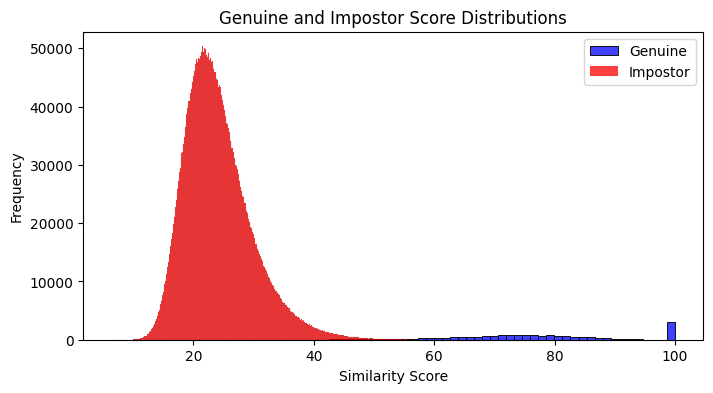

In [13]:
# Step 1b: Plot histograms of Genuine and Impostor scores
plt.figure(figsize=(8, 4))
sns.histplot(genuine_scores, color="blue", label="Genuine", kde=False)
sns.histplot(impostor_scores, color="red", label="Impostor", kde=False)
plt.title('Genuine and Impostor Score Distributions')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.legend()

plt.savefig('genuine_impostor_scores_distribution1.png')

plt.show()

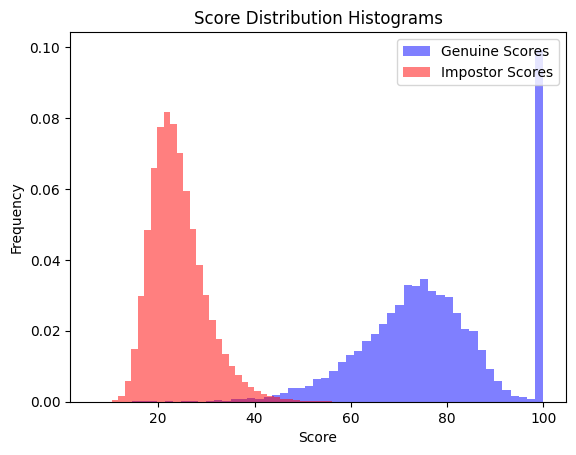

In [18]:
# Plot the score distribution histograms
plt.hist(genuine_scores, bins=50, alpha=0.5, label='Genuine Scores', color='blue', density=True)
plt.hist(impostor_scores, bins=50, alpha=0.5, label='Impostor Scores', color='red', density=True)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Score Distribution Histograms')

plt.savefig('genuine_impostor_scores_distribution2.png')
plt.show()


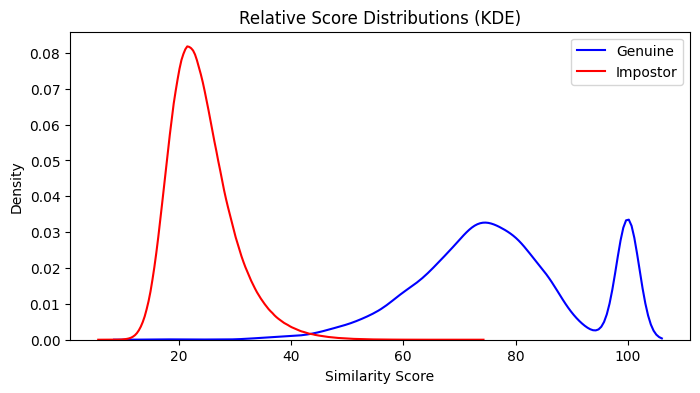

In [19]:
# Step 1c: Plot relative score distribution (KDE plot)
plt.figure(figsize=(8, 4))
sns.kdeplot(genuine_scores, color="blue", label="Genuine")
sns.kdeplot(impostor_scores, color="red", label="Impostor")
plt.title('Relative Score Distributions (KDE)')
plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.legend()

plt.savefig('relative_score_distribution.png')
plt.show()

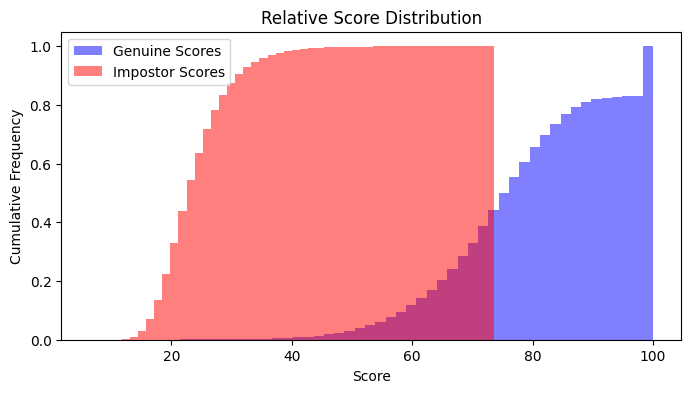

In [20]:
# Plot the relative score distribution
plt.figure(figsize=(8, 4))
plt.hist(genuine_scores, bins=50, alpha=0.5, label='Genuine Scores', color='blue', density=True, cumulative=True)
plt.hist(impostor_scores, bins=50, alpha=0.5, label='Impostor Scores', color='red', density=True, cumulative=True)
plt.xlabel('Score')
plt.ylabel('Cumulative Frequency')
plt.legend(loc='upper left')
plt.title('Relative Score Distribution')

plt.savefig('relative_score_distribution1.png')
plt.show()

In [21]:
# Step 2: D-prime calculation function
def calculate_d_prime(genuine_scores, impostor_scores):
    # Calculate the mean and standard deviation of the genuine and impostor scores
    mu_genuine = np.mean(genuine_scores)
    mu_impostor = np.mean(impostor_scores)
    
    sigma_genuine = np.std(genuine_scores)
    sigma_impostor = np.std(impostor_scores)
    
    # Compute d-prime
    d_prime = (mu_genuine - mu_impostor) / np.sqrt(0.5 * (sigma_genuine**2 + sigma_impostor**2))
    return d_prime

In [22]:
# Call the function to calculate d-prime
d_prime_value = calculate_d_prime(genuine_scores, impostor_scores)

In [23]:
# Output the result
print(f'D-prime value: {d_prime_value}')

D-prime value: 4.850397233180535


In [24]:
# Combine genuine and impostor scores into one array
y_true = np.concatenate([np.ones(len(genuine_scores)), np.zeros(len(impostor_scores))])
y_scores = np.concatenate([genuine_scores, impostor_scores])

In [29]:
# Step 3a: Calculate TPR and FPR for various thresholds using roc_curve from sklearn
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
# Step 3b: Compute AUC
roc_auc = auc(fpr, tpr)

0.9989111935970706


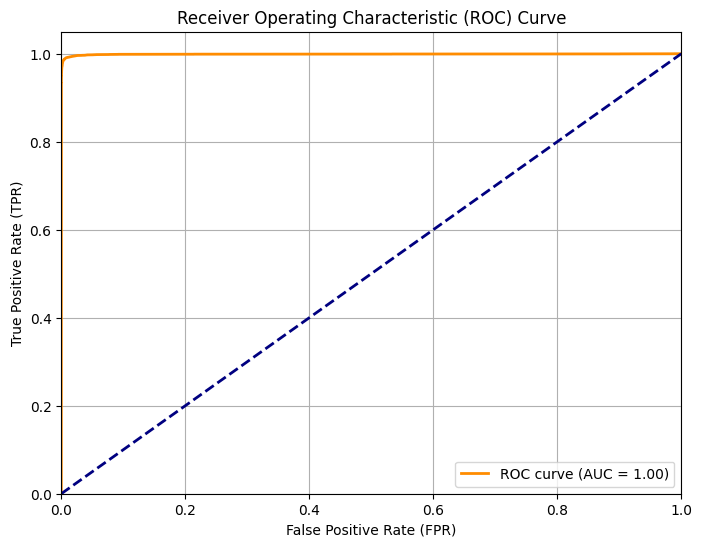

In [28]:
# Step 3b: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc.png')

plt.show()

In [30]:
# Output the AUC result
print(f'Area Under the Curve (AUC): {roc_auc}')

Area Under the Curve (AUC): 0.9989111935970706


In [31]:
# Function to calculate the CMC curve
def calculate_cmc(sim_mat, labels, image_to_subject):
    num_images = len(labels)
    subjects = list(set(image_to_subject.values()))  # Unique subjects
    num_subjects = len(subjects)
    
    cmc_curve = np.zeros(num_subjects)  # CMC curve to store rank percentages

    for i in range(num_images):
        # The probe image and its true subject
        probe_label = labels[i]
        probe_subject = image_to_subject[probe_label]

        # Get similarity scores for this probe image compared to all other gallery images
        similarity_scores = sim_mat[i, :]
        
        # Get the true ranks of the gallery images, sorted by similarity score in descending order
        sorted_indices = np.argsort(-similarity_scores)  # Sort in descending order
        sorted_subjects = [image_to_subject[labels[j]] for j in sorted_indices]

        # Find the rank of the correct match (the first occurrence of the probe's subject in the sorted list)
        correct_rank = sorted_subjects.index(probe_subject)

        # Update the CMC curve (increment all ranks from correct_rank to the end)
        cmc_curve[correct_rank:] += 1
    
    # Normalize the CMC curve (convert counts to percentages)
    cmc_curve = cmc_curve / num_images * 100

    return cmc_curve

In [32]:
# Calculate the CMC curve
cmc_curve = calculate_cmc(sim_mat, labels, image_to_subject)

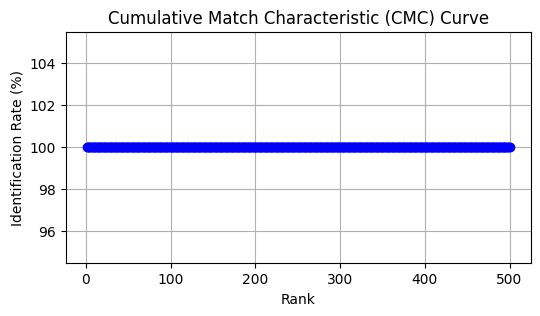

In [34]:
# Step 4: Plot the CMC curve
plt.figure(figsize=(6, 3))
plt.plot(np.arange(1, len(cmc_curve) + 1), cmc_curve, marker='o', color='blue', linestyle='-', lw=2)
plt.title('Cumulative Match Characteristic (CMC) Curve')
plt.xlabel('Rank')
plt.ylabel('Identification Rate (%)')
plt.grid(True)

plt.savefig('cmc.png')
plt.show()

In [36]:
from pyeer.eer_info import get_eer_stats

In [37]:
# Calculate EER statistics
stats = get_eer_stats(genuine_scores, impostor_scores)

In [42]:
# Extract FMR and FNMR values
fmr = stats.fmr
fnmr = stats.fnmr
thresholds = stats.thrs

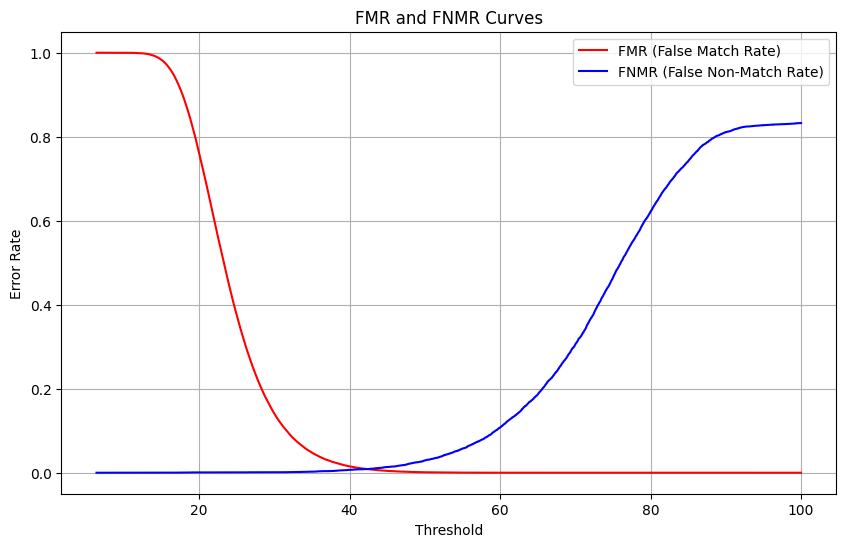

In [43]:
# Plot FMR and FNMR curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fmr, label="FMR (False Match Rate)", color='red')
plt.plot(thresholds, fnmr, label="FNMR (False Non-Match Rate)", color='blue')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('FMR and FNMR Curves')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Find the optimal threshold where FMR and FNMR are closest
optimal_threshold_idx = np.argmin(np.abs(fmr - fnmr))
optimal_threshold = thresholds[optimal_threshold_idx]
print(f'Optimal threshold where FMR and FNMR are closest: {optimal_threshold}')

Optimal threshold where FMR and FNMR are closest: 19.503


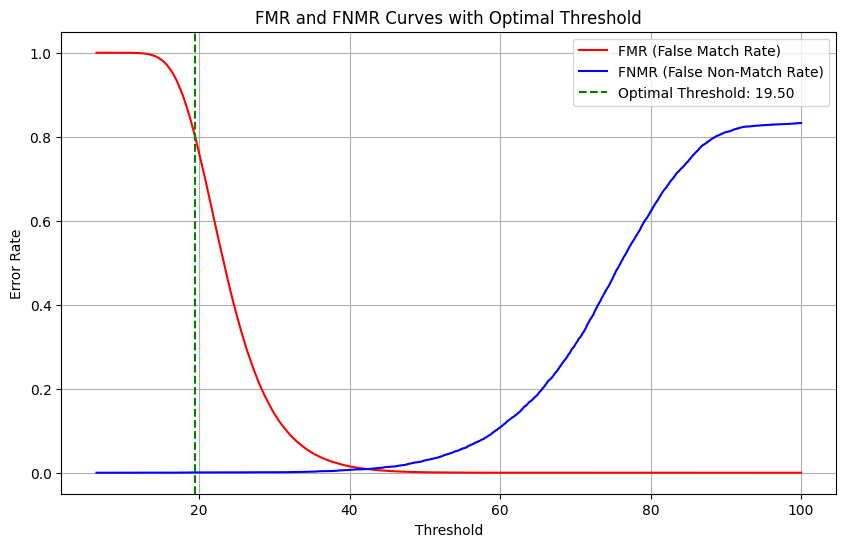

In [44]:
# Highlight the optimal threshold on the plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fmr, label="FMR (False Match Rate)", color='red')
plt.plot(thresholds, fnmr, label="FNMR (False Non-Match Rate)", color='blue')
plt.axvline(x=optimal_threshold, color='green', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('FMR and FNMR Curves with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Function to calculate FMR and FNMR at different thresholds
def calculate_fmr_fnmr(genuine_scores, impostor_scores, thresholds):
    fmr = []
    fnmr = []

    # Loop through each threshold
    for threshold in thresholds:
        # False Match Rate (FMR) calculation
        false_matches = np.sum(impostor_scores >= threshold)
        true_negatives = np.sum(impostor_scores < threshold)
        fmr.append(false_matches / (false_matches + true_negatives))

        # False Non-Match Rate (FNMR) calculation
        false_non_matches = np.sum(genuine_scores < threshold)
        true_positives = np.sum(genuine_scores >= threshold)
        fnmr.append(false_non_matches / (false_non_matches + true_positives))
    
    return np.array(fmr), np.array(fnmr)

In [46]:
# Generate thresholds based on the range of scores
min_score = min(np.min(genuine_scores), np.min(impostor_scores))
max_score = max(np.max(genuine_scores), np.max(impostor_scores))
thresholds = np.linspace(min_score, max_score, 100)  # 100 thresholds

# Calculate FMR and FNMR for each threshold
fmr, fnmr = calculate_fmr_fnmr(genuine_scores, impostor_scores, thresholds)

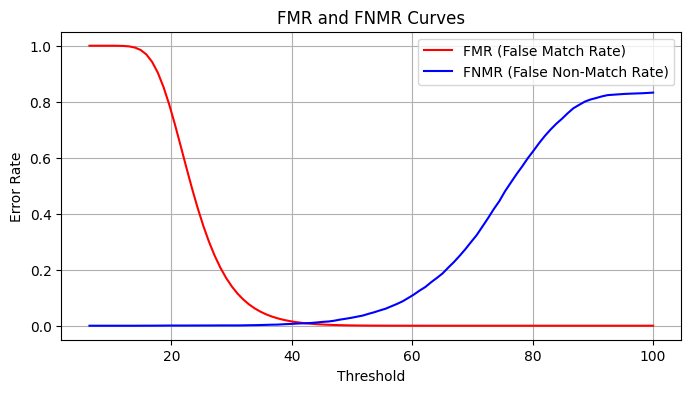

In [51]:
# Step 5a: Plot FMR and FNMR curves
plt.figure(figsize=(8, 4))
plt.plot(thresholds, fmr, label="FMR (False Match Rate)", color='red')
plt.plot(thresholds, fnmr, label="FNMR (False Non-Match Rate)", color='blue')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('FMR and FNMR Curves')
plt.legend()
plt.grid(True)
plt.savefig('fmr.png')
plt.show()

In [48]:
# Step 5b: Find the operating threshold that minimizes the absolute difference between FMR and FNMR
optimal_threshold_idx = np.argmin(np.abs(fmr - fnmr))
optimal_threshold = thresholds[optimal_threshold_idx]

In [49]:
print(f'Optimal threshold where FMR and FNMR are closest: {optimal_threshold}')

Optimal threshold where FMR and FNMR are closest: 42.31371717171717


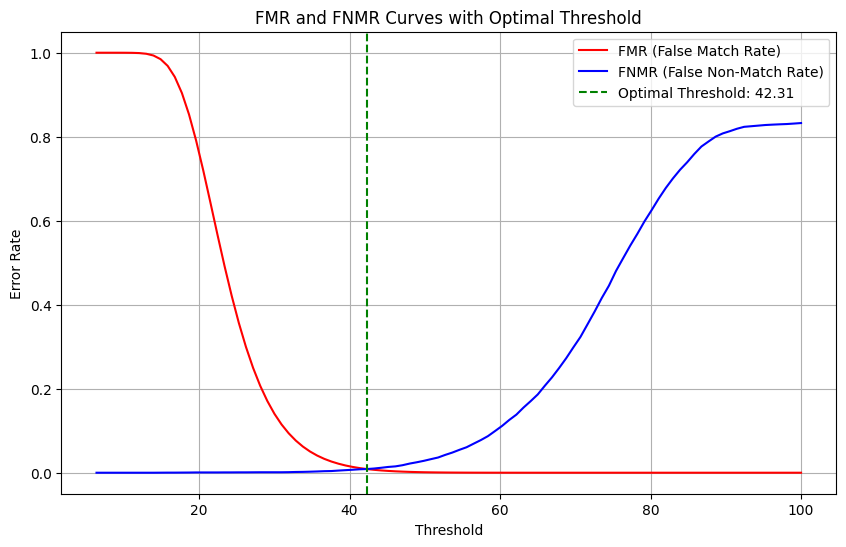

In [52]:
# Highlight the optimal threshold on the plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fmr, label="FMR (False Match Rate)", color='red')
plt.plot(thresholds, fnmr, label="FNMR (False Non-Match Rate)", color='blue')
plt.axvline(x=optimal_threshold, color='green', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('FMR and FNMR Curves with Optimal Threshold')
plt.legend()
plt.grid(True)

plt.savefig('fmr with optimal.png')

plt.show()